In [17]:
# Imports and config
import sys
sys.path.append("../src")
from precomputed_dataset import precomputedDataset
from model import MPNNTransformerModel

import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader as PyGDataLoader

config = {
    # Tier 1
    "lr": 9.89e-4,
    "mpnn_hidden_dim": 64,
    "mpnn_num_layers": 4,
    "attn_num_heads": 8,
    "attn_num_layers": 6,
    "token_dim": 64,
    "pooling_strategy": "mean_pooling",
    # Tier 2
    "weight_decay": 0.0,
    "dropout": 0.1,
    "mp_layer_norm": False,
    # Fixed
    "train_batch_size": 128,
    "val_batch_size": 256,
    "scheduler_min_lr": 5e-6,
    "head_mlp_hidden_dim": 256,
    "gradient_clip_max_norm": 1.0,
    "num_output_sources": 1,
    "node_in_dim": 6,
    "edge_in_dim": 6,
    # Training
    "epochs": 120,
    "seed": 0,
    "device": "cuda:2",
    "train_path": "/mnt/data/zaid/projects/simulated_data/step_2_3.h5",
    "val_path": "/mnt/data/zaid/projects/simulated_data/validation.h5",
}

In [18]:
# Setup
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
torch.cuda.manual_seed_all(config["seed"])

device = config["device"]

train_ds = precomputedDataset(config["train_path"])
val_ds = precomputedDataset(config["val_path"])

train_loader = PyGDataLoader(train_ds, batch_size=config["train_batch_size"], shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
val_loader = PyGDataLoader(val_ds, batch_size=config["val_batch_size"], shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

model = MPNNTransformerModel(
    node_in_dim=config["node_in_dim"],
    edge_in_dim=config["edge_in_dim"],
    num_output_sources=config["num_output_sources"],
    mpnn_hidden_dim=config["mpnn_hidden_dim"],
    mpnn_num_layers=config["mpnn_num_layers"],
    token_dim=config["token_dim"],
    attn_num_heads=config["attn_num_heads"],
    attn_num_layers=config["attn_num_layers"],
    pooling_strategy=config["pooling_strategy"],
    head_mlp_hidden_dim=config["head_mlp_hidden_dim"],
    mp_layer_norm=config["mp_layer_norm"],
    mpnn_dropout=config["dropout"],
    attn_dropout=config["dropout"],
    head_dropout=config["dropout"],
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"], eta_min=config["scheduler_min_lr"])

print(f"Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")


Parameters: 554,563
Train samples: 62500, Val samples: 62500


In [19]:
# Training loop
history = {"train_loss": [], "train_loc": [], "train_str": [], "val_loss": [], "val_loc": [], "val_str": [], "lr": []}

best_val_loss = float("inf")
best_epoch = 0

for epoch in range(1, config["epochs"] + 1):
    # --- Train ---
    model.train()
    epoch_loss = epoch_loc = epoch_str = 0.0

    for data in train_loader:
        data = data.to(device)
        pred_loc, pred_str = model.forward_from_data(data)
        loss_loc = F.mse_loss(pred_loc, data.y)
        loss_str = F.mse_loss(pred_str, data.strength)
        loss = loss_loc + loss_str

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config["gradient_clip_max_norm"])
        optimizer.step()

        epoch_loss += loss.item()
        epoch_loc += loss_loc.item()
        epoch_str += loss_str.item()

    n = len(train_loader)
    epoch_loss /= n; epoch_loc /= n; epoch_str /= n

    # --- Validate ---
    model.eval()
    val_loss_total = val_loc_total = val_str_total = 0.0
    num_samples = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            pred_loc, pred_str = model.forward_from_data(data)
            val_loc_total += F.mse_loss(pred_loc, data.y, reduction="sum").item()
            val_str_total += F.mse_loss(pred_str, data.strength, reduction="sum").item()
            num_samples += pred_loc.size(0)

    val_loss = (val_loc_total + val_str_total) / num_samples
    val_loc = val_loc_total / num_samples
    val_str = val_str_total / num_samples

    # --- Track ---
    history["train_loss"].append(epoch_loss)
    history["train_loc"].append(epoch_loc)
    history["train_str"].append(epoch_str)
    history["val_loss"].append(val_loss)
    history["val_loc"].append(val_loc)
    history["val_str"].append(val_str)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

    # --- Log ---
    print(
        f"Epoch {epoch:4d} | "
        f"Train: {epoch_loss:.6f} (loc={epoch_loc:.6f} str={epoch_str:.6f}) | "
        f"Val: {val_loss:.6f} (loc={val_loc:.6f} str={val_str:.6f}) | "
        f"Best: {best_val_loss:.6f} @ ep{best_epoch} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e}"
    )
    
    #scheduler.step()


Epoch    1 | Train: 0.044760 (loc=0.015317 str=0.029443) | Val: 0.032814 (loc=0.022147 str=0.010668) | Best: 0.032814 @ ep1 | LR: 9.89e-04
Epoch    2 | Train: 0.013926 (loc=0.008797 str=0.005129) | Val: 0.017408 (loc=0.013892 str=0.003516) | Best: 0.017408 @ ep2 | LR: 9.89e-04
Epoch    3 | Train: 0.010240 (loc=0.007006 str=0.003234) | Val: 0.022177 (loc=0.019353 str=0.002824) | Best: 0.017408 @ ep2 | LR: 9.89e-04
Epoch    4 | Train: 0.009069 (loc=0.006110 str=0.002959) | Val: 0.013049 (loc=0.010234 str=0.002815) | Best: 0.013049 @ ep4 | LR: 9.89e-04
Epoch    5 | Train: 0.008516 (loc=0.005714 str=0.002802) | Val: 0.013046 (loc=0.010748 str=0.002297) | Best: 0.013046 @ ep5 | LR: 9.89e-04
Epoch    6 | Train: 0.007921 (loc=0.005229 str=0.002692) | Val: 0.014040 (loc=0.009779 str=0.004262) | Best: 0.013046 @ ep5 | LR: 9.89e-04
Epoch    7 | Train: 0.007468 (loc=0.004946 str=0.002522) | Val: 0.010860 (loc=0.008538 str=0.002322) | Best: 0.010860 @ ep7 | LR: 9.89e-04
Epoch    8 | Train: 0.00714

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 179, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 
Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 179, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 
Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 179, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

NameError: name 'history' is not defined

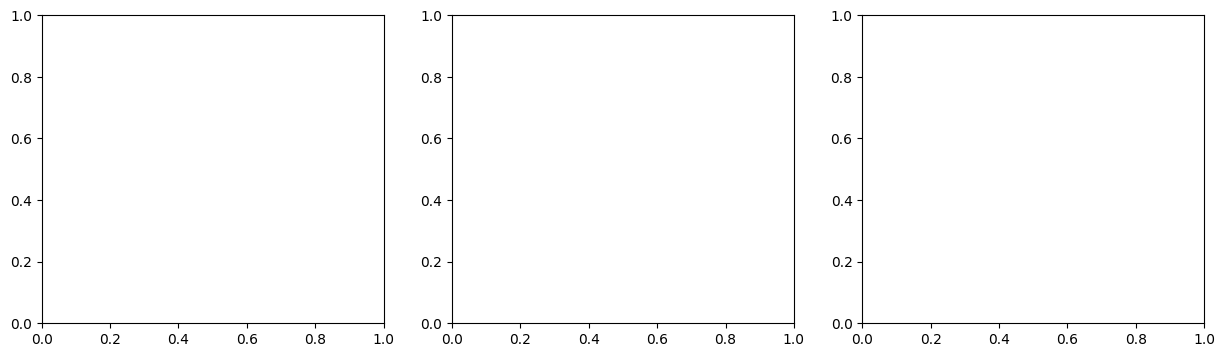

In [ ]:
# Plot curves
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history["train_loss"], label="train")
axes[0].plot(history["val_loss"], label="val")
axes[0].axvline(best_epoch - 1, color="red", linestyle="--", alpha=0.5, label=f"best @ {best_epoch}")
axes[0].set_title("Total Loss")
axes[0].legend()

axes[1].plot(history["train_loc"], label="train")
axes[1].plot(history["val_loc"], label="val")
axes[1].set_title("Location Loss")
axes[1].legend()

axes[2].plot(history["train_str"], label="train")
axes[2].plot(history["val_str"], label="val")
axes[2].set_title("Strength Loss")
axes[2].legend()

for ax in axes:
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest val_loss: {best_val_loss:.6f} at epoch {best_epoch}")
print(f"Epochs after best: {len(history['val_loss']) - best_epoch}")
